In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint

import collections
import re

import datetime
import pickle
import dill

from scipy.signal import find_peaks

# Analysis for new idea: Vaccine timing and outbreak cycles

Begin by developing treatment combinations

In [117]:
dirname = "sims/2023-02-15/"
flist = [dirname + x for x in os.listdir(dirname) if '.pgz' in x]

In [236]:
# Functions for analysis
from scipy.signal import find_peaks

def process_sim(f):
    # Parse beta0 and beta1 from file name
    beta = {s.split("_")[0]: float(s.split("_")[1]) for s in f.split("/")[2].split("__")[0:2]}
    with gzip.open(f, 'rb') as f:
        sim = pickle.load(f)
        
    vu = np.mean(sim._pop[:,[i for i,x in enumerate(sim._colnames) if x == "vaccine_priority" ][0]] == 0)
    
    ret = {**beta, 
            'T_REINFECTION': sim._params.T_REINFECTION,
              'BOOSTER_DAY': sim._params.BOOSTER_DAY,
              'VEBOOST': sim._params.VEBOOST,
              'VU': vu}
    N = sim.S[0] + sim.E[0]
    threshold = N * 0.01
    threshold= 2
    x = np.add.reduceat(sim.Cc, np.arange(0, len(sim.Cc), 24))
    peaks, properties = find_peaks(x, height=threshold, distance=30, width=1, rel_height=1)
    
    count = []
    for i in range(len(properties["left_ips"])):
        left_bound = round(properties["left_ips"][i])
        right_bound = round(properties["right_ips"][i])
        count.append(sum(x[left_bound:right_bound]))
            
    ret["num_outbreaks"] = len(peaks)
    ret["mean_time_bw_outbreaks"] = np.mean(np.diff(peaks))
    ret["avg_outbreak_size"] = np.mean(count)
    
    return ret
    

In [237]:
processed_sims = []
for i, fname in enumerate(flist):
    print(i, end="\r")
    processed_sims.append(process_sim(fname))


In [238]:
processed_sims = pd.DataFrame(processed_sims)

Text(0.5, 0, 'Time until reinfection (days)')

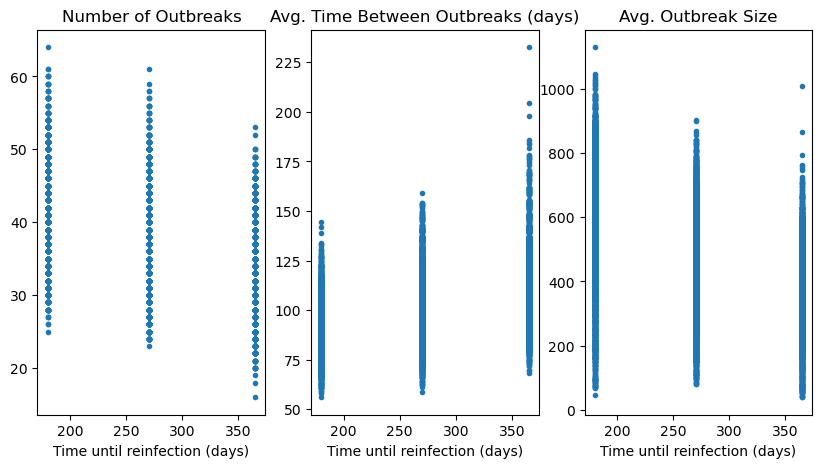

In [215]:
fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.T_REINFECTION/24, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Time until reinfection (days)")
ax[1].plot(processed_sims.T_REINFECTION/24, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Time until reinfection (days)")
ax[2].plot(processed_sims.T_REINFECTION/24, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Time until reinfection (days)")

In [296]:
processed_sims.groupby(["T_REINFECTION"]).agg(np.mean)

,BETA0,BETA1,BOOSTER_DAY,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size,VU_rounded
T_REINFECTION,,,,,,,,,
4320,0.05,0.45,166.5,0.82,0.499502,40.427469,90.835067,605.725604,0.5
6480,0.05,0.45,166.5,0.82,0.499728,36.585185,101.543190,481.471148,0.5
8760,0.05,0.45,166.5,0.82,0.499723,33.329938,111.126547,394.890201,0.5


Text(0.5, 0, 'Booster Day')

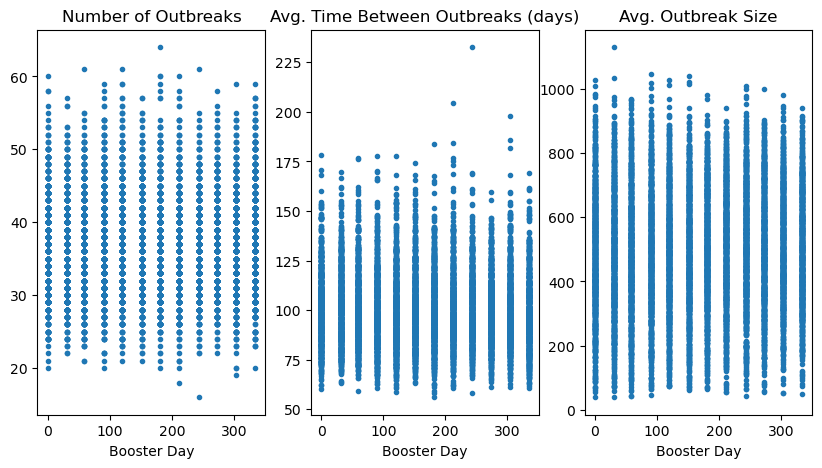

In [190]:
fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.BOOSTER_DAY, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Booster Day")
ax[1].plot(processed_sims.BOOSTER_DAY, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Booster Day")
ax[2].plot(processed_sims.BOOSTER_DAY, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Booster Day")

In [297]:
processed_sims.groupby(["BOOSTER_DAY"]).agg(np.mean)

,BETA0,BETA1,T_REINFECTION,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size,VU_rounded
BOOSTER_DAY,,,,,,,,,
0,0.05,0.45,6520.0,0.82,0.499941,36.330864,102.641514,485.507756,0.5
31,0.05,0.45,6520.0,0.82,0.499725,36.420988,102.266321,483.292373,0.5
59,0.05,0.45,6520.0,0.82,0.499437,36.482716,101.960628,481.538566,0.5
90,0.05,0.45,6520.0,0.82,0.499418,36.766667,101.409346,483.434126,0.5
120,0.05,0.45,6520.0,0.82,0.499273,37.164198,100.506951,482.922712,0.5
151,0.05,0.45,6520.0,0.82,0.499673,36.811111,101.122795,489.282063,0.5
181,0.05,0.45,6520.0,0.82,0.499917,36.774074,101.099799,500.336912,0.5
212,0.05,0.45,6520.0,0.82,0.499403,36.746914,101.198310,503.434852,0.5
243,0.05,0.45,6520.0,0.82,0.499805,36.596296,101.347471,508.384130,0.5


Text(0.5, 0, 'Vaccine Uptake Rate')

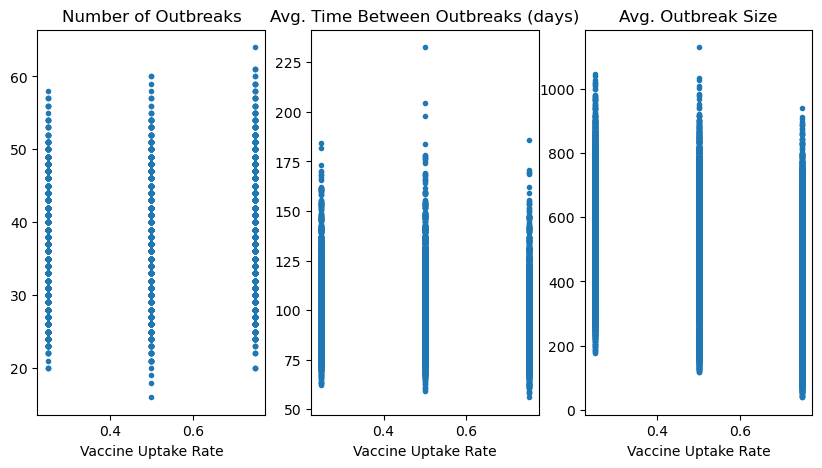

In [300]:
def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]

processed_sims["VU_rounded"] = [closest_value([0.25, 0.5, 0.75], x) for x in processed_sims.VU]

fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.VU_rounded, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Vaccine Uptake Rate")
ax[1].plot(processed_sims.VU_rounded, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Vaccine Uptake Rate")
ax[2].plot(processed_sims.VU_rounded, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Vaccine Uptake Rate")

In [301]:
processed_sims.groupby(["VU_rounded"]).agg(np.mean)

,BETA0,BETA1,T_REINFECTION,BOOSTER_DAY,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size
VU_rounded,,,,,,,,,
0.25,0.05,0.45,6520.0,166.5,0.82,0.249449,35.849691,103.708844,556.802398
0.50,0.05,0.45,6520.0,166.5,0.82,0.499653,36.150617,103.160246,504.947386
0.75,0.05,0.45,6520.0,166.5,0.82,0.749850,38.342284,96.635714,420.337169


# Calculating Average Treatment Effect

6 treatment variables: BETA0, BETA1, T_REINFECTION, VEBOOST, VU_rounded, BOOSTER_DAY

3 outcome variables: num_outbreaks, mean_time_bw_outbreaks, avg_outbreak_size


In [291]:
processed_sims.groupby(["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "BOOSTER_DAY", "VU_rounded"]).agg(np.mean)

VU  \
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY VU_rounded             
0.01  0.0   4320          0.82    0           0.25        0.242143   
                                              0.50        0.507480   
                                              0.75        0.756676   
                                  31          0.25        0.233697   
                                              0.50        0.513866   
...                                                            ...   
0.09  0.9   8760          0.82    304         0.50        0.498098   
                                              0.75        0.759378   
                                  334         0.25        0.242507   
                                              0.50        0.490648   
                                              0.75        0.743394   

                                                          num_outbreaks  \
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY VU_rounded                  
0.01  0.0   4320          0.82    0           0.25                 37.0   
                                              0.50                 44.0   
                                              0.75                 42.0   
                                  31          0.25                 43.0   
                                              0.50                 43.0   
...                                                                 ...   
0.09  0.9   8760          0.82    304         0.50                 40.0   
                                              0.75                 47.0   
                                  334         0.25                 42.0   
                                              0.50                 30.0   
                                              0.75                 46.0   

                                                          mean_time_bw_outbreaks  \
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY VU_rounded                           
0.01  0.0   4320          0.82    0           0.25                     97.416667   
                                              0.50                     82.418605   
                                              0.75                     86.024390   
                                  31          0.25                     84.619048   
                                              0.50                     83.666667   
...                                                                          ...   
0.09  0.9   8760          0.82    304         0.50                     90.717949   
                                              0.75                     77.543478   
                                  334         0.25                     85.487805   
                                              0.50                    121.724138   
                                              0.75                     78.622222   

                                                          avg_outbreak_size  
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY VU_rounded                     
0.01  0.0   4320          0.82    0           0.25               442.594595  
                                              0.50               207.863636  
                                              0.75                96.738095  
                                  31          0.25               357.069767  
                                              0.50               207.093023  
...                                                                     ...  
0.09  0.9   8760          0.82    304         0.50               369.700000  
                                              0.75               310.021277  
                                  334         0.25               372.642857  
                                              0.50               502.700000  
                                              0.75               302.347826  

[9720 rows x 4 columns]

In [295]:
np.mean(processed_sims[processed_sims.BETA1 > 0.5].avg_outbreak_size)
np.mean(processed_sims[processed_sims.BETA1 < 0.5].avg_outbreak_size)

529.7355745678086

## Booster Day

In [345]:
# Let's start with one easy one. BOOSTER_DAY = march 1st (day 59) vs sept 1st (243)
booster_day_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])
booster_day_df

avg_outbreak_size              \
BOOSTER_DAY                                                0           31    
BETA0 BETA1 T_REINFECTION VEBOOST VU_rounded                                 
0.01  0.0   4320          0.82    0.25              442.594595  357.069767   
                                  0.50              207.863636  207.093023   
                                  0.75               96.738095   73.744681   
            6480          0.82    0.25              246.142857  278.450000   
                                  0.50              201.210526  177.850000   
...                                                        ...         ...   
0.09  0.9   6480          0.82    0.50              421.644444  412.847826   
                                  0.75              368.638298  334.000000   
            8760          0.82    0.25              341.720930  323.622222   
                                  0.50              391.189189  342.547619   
                                  0.75              403.970588  353.815789   

                                                                      \
BOOSTER_DAY                                          59          90    
BETA0 BETA1 T_REINFECTION VEBOOST VU_rounded                           
0.01  0.0   4320          0.82    0.25        314.122449  405.131579   
                                  0.50        215.652174  275.289474   
                                  0.75         89.061224   83.770833   
            6480          0.82    0.25        286.205128  332.636364   
                                  0.50        217.718750  164.575000   
...                                                  ...         ...   
0.09  0.9   6480          0.82    0.50        370.020000  502.135135   
                                  0.75        409.175000  337.811321   
            8760          0.82    0.25        357.523810  372.682927   
                                  0.50        441.852941  336.772727   
                                  0.75        372.394737  340.880952   

                                                                      \
BOOSTER_DAY                                          120         151   
BETA0 BETA1 T_REINFECTION VEBOOST VU_rounded                           
0.01  0.0   4320          0.82    0.25        372.292683  355.243902   
                                  0.50        187.411765  169.686275   
                                  0.75         76.877551   92.673469   
            6480          0.82    0.25        279.205128  336.342857   
                                  0.50        166.707317  185.777778   
...                                                  ...         ...   
0.09  0.9   6480          0.82    0.50        474.800000  407.145833   
                                  0.75        416.116279  469.025000   
            8760          0.82    0.25        355.309524  334.465116   
                                  0.50        387.648649  389.837838   
                                  0.75        419.558824  471.032258   

                                                                      \
BOOSTER_DAY                                          181         212   
BETA0 BETA1 T_REINFECTION VEBOOST VU_rounded                           
0.01  0.0   4320          0.82    0.25        436.125000  380.744186   
                                  0.50        272.136364  298.977273   
                                  0.75        187.769231  194.040816   
            6480          0.82    0.25        285.853659  337.142857   
                                  0.50        182.666667  173.829787   
...                                                  ...         ...   
0.09  0.9   6480          0.82    0.50        486.780488  535.783784   
                                  0.75        435.704545  462.690476   
            8760          0.82    0.25        412.684211  349.674419   
                                  0.50        359.714286  366.658537  

In [332]:
for i in range(1, 12):
    m1 = booster_day_df.avg_outbreak_size.columns[i]
    m0 = booster_day_df.avg_outbreak_size.columns[i-1]
    
    mte = np.mean(booster_day_df["avg_outbreak_size"][m1] - booster_day_df["avg_outbreak_size"][m0])
    mte = np.mean(booster_day_df["mean_time_bw_outbreaks"][m1] - booster_day_df["mean_time_bw_outbreaks"][m0])
    mte = np.mean(booster_day_df["num_outbreaks"][m1] - booster_day_df["num_outbreaks"][m0])
    
    print(mte)

0.09012345679012346
0.06172839506172839
0.2839506172839506
0.39753086419753086
-0.3530864197530864
-0.037037037037037035
-0.027160493827160494
-0.1506172839506173
0.19876543209876543
0.0345679012345679
0.8222222222222222


## Vaccine uptake

In [344]:
vu_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "BOOSTER_DAY"],
    columns = "VU_rounded",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])
vu_df

avg_outbreak_size              \
VU_rounded                                                 0.25        0.50   
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY                                 
0.01  0.0   4320          0.82    0                  442.594595  207.863636   
                                  31                 357.069767  207.093023   
                                  59                 314.122449  215.652174   
                                  90                 405.131579  275.289474   
                                  120                372.292683  187.411765   
...                                                         ...         ...   
0.09  0.9   8760          0.82    212                349.674419  366.658537   
                                  243                393.631579  389.000000   
                                  273                431.459459  405.710526   
                                  304                399.282051  369.700000   
                                  334                372.642857  502.700000   

                                                           \
VU_rounded                                           0.75   
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY               
0.01  0.0   4320          0.82    0             96.738095   
                                  31            73.744681   
                                  59            89.061224   
                                  90            83.770833   
                                  120           76.877551   
...                                                   ...   
0.09  0.9   8760          0.82    212          359.050000   
                                  243          305.977273   
                                  273          383.368421   
                                  304          310.021277   
                                  334          302.347826   

                                              mean_time_bw_outbreaks  \
VU_rounded                                                      0.25   
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY                          
0.01  0.0   4320          0.82    0                        97.416667   
                                  31                       84.619048   
                                  59                       74.687500   
                                  90                       95.648649   
                                  120                      89.000000   
...                                                              ...   
0.09  0.9   8760          0.82    212                      84.142857   
                                  243                      94.216216   
                                  273                      97.527778   
                                  304                      92.552632   
                                  334                      85.487805   

                                                                      \
VU_rounded                                           0.50       0.75   
BETA0 BETA1 T_REINFECTION VEBOOST BOOSTER_DAY                          
0.01  0.0   4320          0.82    0             82.418605  86.024390   
                                  31            83.666667  76.760870   
                                  59            77.200000  74.666667   
                                  90            94.162162  74.361702   
                                  120           69.840000  73.895833   
...                                                   ...        ...   
0.09  0.9   8760          0.82    212           88.675000  90.410256   
                                  243           97.833333  82.186047   
                                  273           96.459459  95.864865   
                                  304           90.717949  77.543478   
                                  334          121.724138  78.622222   

                                              num_outbreaks       

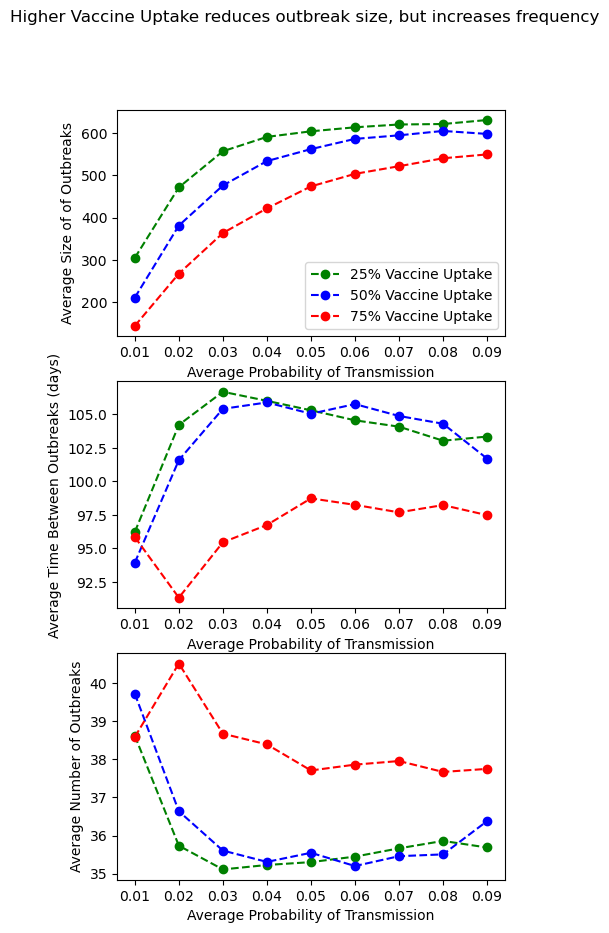

In [483]:
fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]

for i, o in enumerate(outcomes):
    v25 = []
    v50 = []
    v75 = []
    b0_vec = vu_df[o].index.levels[0]
    for b0 in b0_vec:

        v25.append(np.mean(vu_df[o][0.25].loc[b0]))
        v50.append(np.mean(vu_df[o][0.50].loc[b0]))
        v75.append(np.mean(vu_df[o][0.75].loc[b0]))

    ax[i].plot(b0_vec, v25, "--go", label = "25% Vaccine Uptake")
    ax[i].plot(b0_vec, v50, "--bo", label = "50% Vaccine Uptake")
    ax[i].plot(b0_vec, v75, "--ro", label = "75% Vaccine Uptake")
    
    
ax[0].legend()
    
# ax[0].set_title("Higher Vaccine Uptake reduces outbreak size at all transmission probabilities")
ax[0].set_xlabel("Average Probability of Transmission")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Average Probability of Transmission")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Average Probability of Transmission")
ax[2].set_ylabel("Average Number of Outbreaks")
#ax[0].set_ylabel("Average Clinical Infections per Outbreak")

plt.suptitle("Higher Vaccine Uptake reduces outbreak size, but increases frequency")
plt.show()


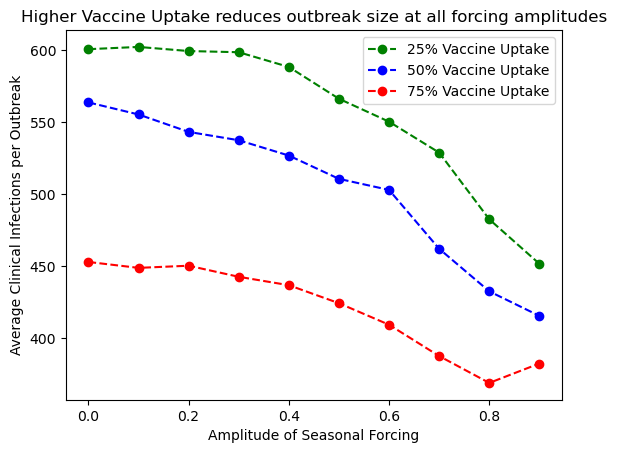

In [470]:
fig, ax = plt.subplots()

v25 = []
v50 = []
v75 = []
b1_vec = vu_df["avg_outbreak_size"].index.levels[1]
for b1 in b1_vec:
    
    v25.append(np.mean(vu_df["avg_outbreak_size"][0.25].loc[:, b1]))
    v50.append(np.mean(vu_df["avg_outbreak_size"][0.50].loc[:, b1]))
    v75.append(np.mean(vu_df["avg_outbreak_size"][0.75].loc[:, b1]))
    
ax.plot(b1_vec, v25, "--go", label = "25% Vaccine Uptake")
ax.plot(b1_vec, v50, "--bo", label = "50% Vaccine Uptake")
ax.plot(b1_vec, v75, "--ro", label = "75% Vaccine Uptake")
ax.legend()
ax.set_title("Higher Vaccine Uptake reduces outbreak size at all forcing amplitudes")
ax.set_xlabel("Amplitude of Seasonal Forcing")
ax.set_ylabel("Average Clinical Infections per Outbreak")
    
plt.show()



# Month of Vaccination

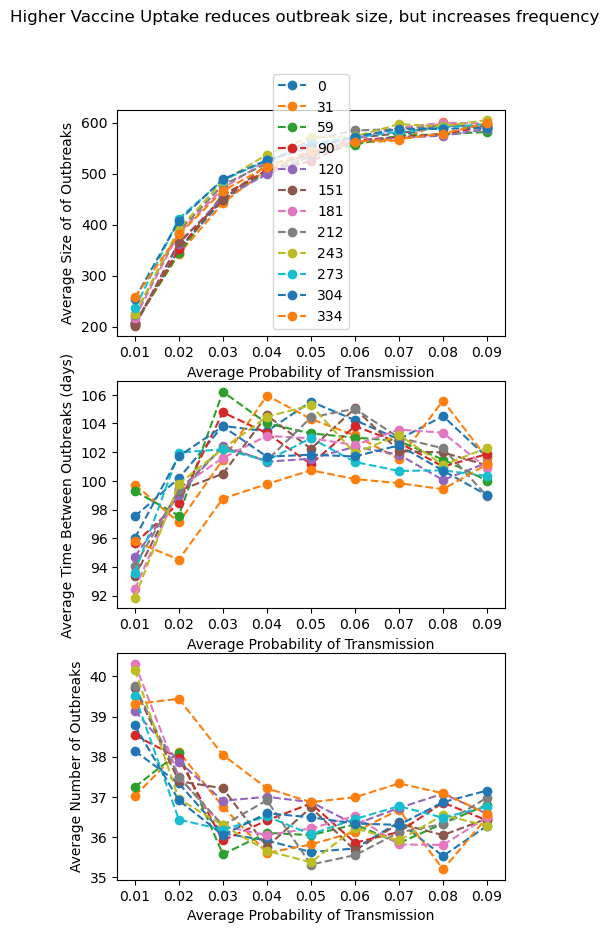

In [515]:
bd_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])

fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]
months = bd_df["num_outbreaks"].columns

for i, o in enumerate(outcomes):
    df = pd.DataFrame(columns = months)
    b0_vec = bd_df[o].index.levels[0]
    for b0 in b0_vec:
        tmp = pd.DataFrame([{k: np.mean(bd_df[o][k].loc[b0]) for k in months}])
        df = pd.concat([df, tmp], ignore_index=True)

    for m in months:
        ax[i].plot(b0_vec, df.loc[:,m], "--o", label = m)
    
    
ax[0].legend()
    
ax[0].set_xlabel("Average Probability of Transmission")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Average Probability of Transmission")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Average Probability of Transmission")
ax[2].set_ylabel("Average Number of Outbreaks")

plt.suptitle("No obvious effect of Month of Vaccination on outcomes across b0")
plt.show()


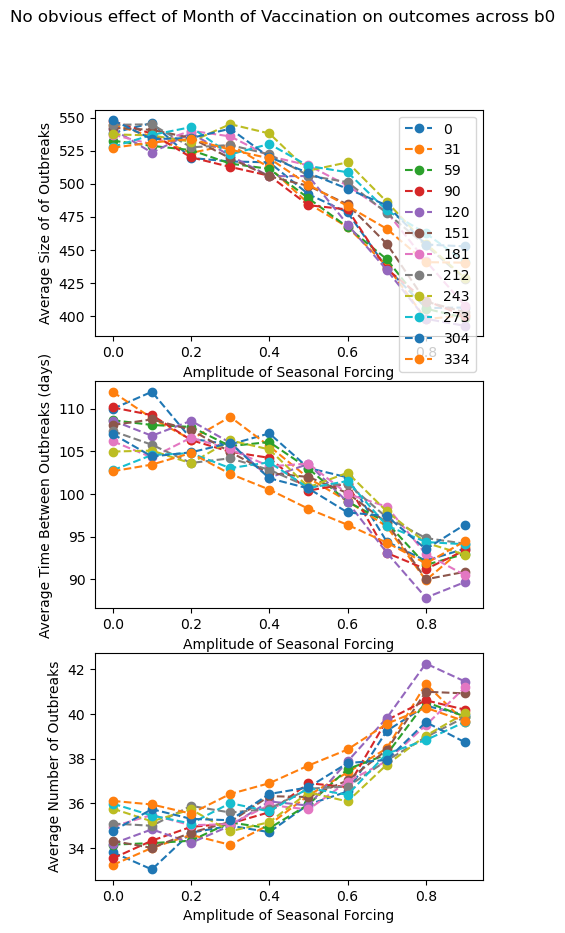

In [517]:
bd_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])

fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]
months = bd_df["num_outbreaks"].columns

for i, o in enumerate(outcomes):
    df = pd.DataFrame(columns = months)
    b1_vec = bd_df[o].index.levels[1]
    for b1 in b1_vec:
        tmp = pd.DataFrame([{k: np.mean(bd_df[o][k].loc[:,b1]) for k in months}])
        df = pd.concat([df, tmp], ignore_index=True)

    for m in months:
        ax[i].plot(b1_vec, df.loc[:,m], "--o", label = m)
    
    
ax[0].legend()
    
ax[0].set_xlabel("Amplitude of Seasonal Forcing")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Amplitude of Seasonal Forcing")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Amplitude of Seasonal Forcing")
ax[2].set_ylabel("Average Number of Outbreaks")

plt.suptitle("No obvious effect of Month of Vaccination on outcomes across b0")
plt.show()


## Month of vaccination with t_reinf

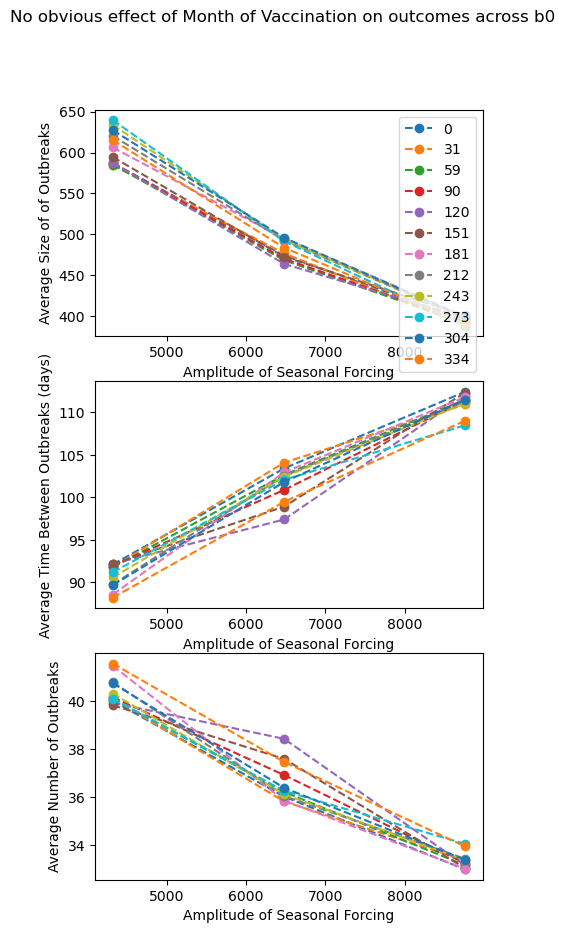

In [519]:
bd_df = processed_sims.drop(
    "VU", axis=1
).pivot_table(
    index = ["BETA0", "BETA1", "T_REINFECTION", "VEBOOST", "VU_rounded"],
    columns = "BOOSTER_DAY",
    values = ["num_outbreaks", "mean_time_bw_outbreaks", "avg_outbreak_size"])

fig, ax = plt.subplots(3, figsize=(5,10))

outcomes = ["avg_outbreak_size", "mean_time_bw_outbreaks", "num_outbreaks"]
months = bd_df["num_outbreaks"].columns

for i, o in enumerate(outcomes):
    df = pd.DataFrame(columns = months)
    t_vec = bd_df[o].index.levels[2]
    for t in t_vec:
        tmp = pd.DataFrame([{k: np.mean(bd_df[o][k].loc[:,:,t]) for k in months}])
        df = pd.concat([df, tmp], ignore_index=True)

    for m in months:
        ax[i].plot(t_vec, df.loc[:,m], "--o", label = m)
    
    
ax[0].legend()
    
ax[0].set_xlabel("Amplitude of Seasonal Forcing")
ax[0].set_ylabel("Average Size of of Outbreaks")
ax[1].set_xlabel("Amplitude of Seasonal Forcing")
ax[1].set_ylabel("Average Time Between Outbreaks (days)")
ax[2].set_xlabel("Amplitude of Seasonal Forcing")
ax[2].set_ylabel("Average Number of Outbreaks")

plt.suptitle("No obvious effect of Month of Vaccination on outcomes across b0")
plt.show()


# How does transmission affect?

In [250]:
import seaborn as sns

In [255]:
# To do this, group simulations by transmission parameters

# processed_sims.groupby(["BETA0", "BETA1"])
arr = processed_sims[processed_sims.BOOSTER_DAY == 31][["BETA0", "BETA1", "avg_outbreak_size"]]
print(arr)
#arr.pivot("BETA0", "BETA1", "avg_outbreak_size")
#sns.heatmap(data=arr, x="BETA0", y="BETA1", hue="avg_outbreak_size")

      BETA0  BETA1  avg_outbreak_size
0      0.04    0.4         442.933333
1      0.07    0.6         622.717949
27     0.08    0.7         405.694444
28     0.08    0.8         415.200000
49     0.03    0.8         322.360000
...     ...    ...                ...
9644   0.03    0.9         475.904762
9649   0.03    0.6         474.857143
9659   0.03    0.8         288.155556
9679   0.07    0.9         279.204545
9685   0.03    0.4         426.783784

[810 rows x 3 columns]


In [260]:
import statsmodels.api as sm

In [335]:
model = sm.OLS(processed_sims["avg_outbreak_size"],
               processed_sims[["BETA0", "BETA1", "BOOSTER_DAY","T_REINFECTION", "VEBOOST", "VU_rounded"]]).fit()

print(model.summary())

model = sm.OLS(processed_sims["mean_time_bw_outbreaks"],
               processed_sims[["BETA0", "BETA1", "BOOSTER_DAY","T_REINFECTION", "VEBOOST", "VU_rounded"]]).fit()

print(model.summary())

model = sm.OLS(processed_sims["num_outbreaks"],
               processed_sims[["BETA0", "BETA1", "BOOSTER_DAY","T_REINFECTION", "VEBOOST", "VU_rounded"]]).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_outbreak_size   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     4404.
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:44:33   Log-Likelihood:                -58633.
No. Observations:                9720   AIC:                         1.173e+05
Df Residuals:                    9714   BIC:                         1.173e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
BETA0          4026.6254     39.614    101.646

In [342]:
booster_day_df["avg_outbreak_size"].loc[:,0,:,:]

BOOSTER_DAY                                    0           31          59   \
BETA0 T_REINFECTION VEBOOST VU_rounded                                       
0.01  4320          0.82    0.25        442.594595  357.069767  314.122449   
                            0.50        207.863636  207.093023  215.652174   
                            0.75         96.738095   73.744681   89.061224   
      6480          0.82    0.25        246.142857  278.450000  286.205128   
                            0.50        201.210526  177.850000  217.718750   
...                                            ...         ...         ...   
0.09  6480          0.82    0.50        599.114286  778.111111  538.026316   
                            0.75        452.068182  599.393939  629.709677   
      8760          0.82    0.25        490.696970  485.500000  469.583333   
                            0.50        460.411765  662.720000  463.088235   
                            0.75        441.142857  491.906250  545.857143   

BOOSTER_DAY                                    90          120         151  \
BETA0 T_REINFECTION VEBOOST VU_rounded                                       
0.01  4320          0.82    0.25        405.131579  372.292683  355.243902   
                            0.50        275.289474  187.411765  169.686275   
                            0.75         83.770833   76.877551   92.673469   
      6480          0.82    0.25        332.636364  279.205128  336.342857   
                            0.50        164.575000  166.707317  185.777778   
...                                            ...         ...         ...   
0.09  6480          0.82    0.50        833.160000  630.937500  627.852941   
                            0.75        590.882353  597.121212  670.066667   
      8760          0.82    0.25        572.931034  560.733333  503.636364   
                            0.50        644.480000  508.387097  620.192308   
                            0.75        394.897436  562.107143  412.078947   

BOOSTER_DAY                                    181         212          243  \
BETA0 T_REINFECTION VEBOOST VU_rounded                                        
0.01  4320          0.82    0.25        436.125000  380.744186   395.888889   
                            0.50        272.136364  298.977273   296.866667   
                            0.75        187.769231  194.040816   151.344262   
      6480          0.82    0.25        285.853659  337.142857   378.000000   
                            0.50        182.666667  173.829787   152.037037   
...                                            ...         ...          ...   
0.09  6480          0.82    0.50        498.952381  651.242424   664.531250   
                            0.75        599.441176  638.968750   490.475000   
      8760          0.82    0.25        455.540541  562.600000   581.275862   
                            0.50        597.925926  597.777778  1008.875000   
                            0.75        414.594595  409.157895   505.064516   

BOOSTER_DAY                                    273         304         334  
BETA0 T_REINFECTION VEBOOST VU_rounded                                      
0.01  4320          0.82    0.25        327.938776  370.977273  372.869565  
                            0.50        309.906977  337.219512  273.795918  
                            0.75        162.109091  188.166667  184.962264  
      6480          0.82    0.25        252.000000  275.511628  341.833333  
                            0.50        139.500000  207.558140  201.975610  
...                                            ...         ...         ...  
0.09  6480          0.82    0.50        531.025000  537.564103  664.548387  
                            0.75        506.512821  521.615385  560.111111  
      8760          0.82    0.25        473.666667  503.406250  711.416667  
                            0.50        573.344828  568.178571  541.206897  
                  